This notebook contains 2 experiments:
1. Grades Dataset Baseline Model 1: logistic regression with no fairness constraints
2. Grades Dataset Baseline Model 1b: logistic regression, input variables directly related to the protected variable are removed

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from scipy import stats

#Set torch seed
torch.manual_seed(42)

In [2]:
# use the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Import and prepare the data (data from http://www.bristol.ac.uk/cmm/learning/support/datasets)

In [5]:
geom_cols = ['A-SCORE', 'BOARD', 'GCSE-G-SCORE', 'GENDER', 'GTOT', 'GNUM', 'GCSE-MA-MAX', 'GCSE-MA-NUM', 'AGE', 'INST-GA-MN', 'INST-GA-SD', 'INSTTYPE', 'LEA', 'INSTITUTE', 'STUDENT']
df = pd.read_csv("a-level-geography.txt", sep=" ", header=None, names=geom_cols)
print(df.head())

   A-SCORE  BOARD  GCSE-G-SCORE  GENDER  GTOT  GNUM  GCSE-MA-MAX  GCSE-MA-NUM  \
0      8.0      3             6       1    57   8.0            7            1   
1      8.0      3             6       1    50   8.0            6            1   
2      8.0      3             8       1    64   9.0            6            1   
3     10.0      3             8       1    57   8.0            6            1   
4      8.0      3             7       1    57   8.0            7            1   

   AGE  INST-GA-MN  INST-GA-SD  INSTTYPE  LEA  INSTITUTE  STUDENT  
0  1.0       0.856        0.51       7.0  1.0        1.0     25.0  
1 -6.0       0.856        0.51       7.0  1.0        1.0     51.0  
2  5.0       0.856        0.51       7.0  1.0        1.0     69.0  
3 -1.0       0.856        0.51       7.0  1.0        1.0     70.0  
4 -5.0       0.856        0.51       7.0  1.0        1.0     85.0  


In [6]:
#Create binary variable for Protected Group
df['PROTECTED'] = [1 if x == 1 else 0 for x in df['INSTTYPE']] 

#Create binary variable for achieving a C or above in A-Level Geometry
df['ABOVE_C'] = [1 if x >= 6 else 0 for x in df['A-SCORE']] 

In [7]:
df.groupby(["ABOVE_C", "PROTECTED"]).size()

ABOVE_C  PROTECTED
0        0             8040
         1             5774
1        0            12916
         1             6546
dtype: int64

In [8]:
# Create test and training set, apply standard scaler to all except binary variables

X = df[['GCSE-G-SCORE', 'GTOT', 'GNUM', 'GCSE-MA-MAX', 'GCSE-MA-NUM', 'AGE', 'INST-GA-MN', 'INST-GA-SD', 'GENDER', 'PROTECTED']].copy()
feature_names = list(X.columns)
y = df[['ABOVE_C']].copy()
X = X.to_numpy()
y = y.to_numpy()
X, y = shuffle(X, y)

y = y.squeeze()

In [9]:
## Unbalanced classes: apply class weights for both the predictor and the discriminator
neg_weight = y[y == 1].size /y[y == 0].size
class_weights = torch.as_tensor(neg_weight)

neg_A_weight = X[:,9][X[:,9] == 1].size /X[:,9][X[:,9] == 0].size
class_weights_A = torch.as_tensor(neg_A_weight)

In [10]:
print(feature_names)

['GCSE-G-SCORE', 'GTOT', 'GNUM', 'GCSE-MA-MAX', 'GCSE-MA-NUM', 'AGE', 'INST-GA-MN', 'INST-GA-SD', 'GENDER', 'PROTECTED']


In [11]:
protected = X[:,feature_names.index('PROTECTED')] == 1
other = X[:,feature_names.index('PROTECTED')] == 0
protected_mean_base = y[protected].mean()
other_mean_base = y[other].mean()
print(f'\tSample base rate: {protected_mean_base*100:.2f}% C or above for the protected group')
print(f'\tSample base rate: {other_mean_base*100:.2f}% C or above for the rest of the sample')

	Sample base rate: 53.13% C or above for the protected group
	Sample base rate: 61.63% C or above for the rest of the sample


In [12]:
def calc_FNR_FPR(y, y_pred):
    """
    Returns the FNR and FPR
    """
    y = y.numpy()
    y_pred = y_pred.numpy()
    fnr = 1 - y_pred[y == 1].mean()
    fpr = y_pred[y == 0].mean()
    
    return fnr, fpr

In [13]:
def plot_loss_accuracy(train_loss, valid_loss, train_acc, valid_acc, title):
    """
    Plots the loss and accuracy against epochs
    """
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(train_loss, 'b')
    ax1.plot(valid_loss, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title(title)
    ax1.legend(['Train', 'Validation'])  
    
    ax1 = fig.add_subplot(1,2,2)
    ax1.plot(train_acc, 'b')
    ax1.plot(valid_acc, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    ax1.legend(['Train', 'Validation'])

Define and run baseline logistic regression model.

In [14]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10, 1)
    
    def forward(self, x):
        pred_logit = self.linear(x)
        y_pred = torch.sigmoid(pred_logit)
        y_pred = torch.squeeze(y_pred)
        return y_pred

In [16]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    e_pred_probs = np.array([])
    e_preds      = np.array([])
    e_labels = np.array([])
    model.train()

    for i, data in enumerate(iterator, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        pred_probs = model(inputs)
        e_pred_probs = np.append(e_pred_probs, pred_probs.detach().cpu())
        loss = criterion(pred_probs, labels)
        pred = torch.round(pred_probs.detach().cpu().data) 
        acc = accuracy_score(labels.detach().cpu(), pred)
        e_preds = np.append(e_preds, pred.detach().cpu())
        e_labels = np.append(e_labels,labels.detach().cpu())
        
        # backward and optimize
        loss.backward()
        optimizer.step()

        # capture loss and scores
        epoch_loss += loss.item()
        epoch_acc += acc.item()  
    
    f1 =  f1_score(e_labels,e_preds)
    auc = roc_auc_score(e_labels,e_pred_probs) 
    
    # Return average epoch loss, accuracy, F1 and AUC
    return epoch_loss/len(iterator) , epoch_acc / len(iterator), f1, auc

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_f1_o = 0
    epoch_f1_p = 0
    epoch_auc = 0
    epoch_prot_mean = 0
    epoch_other_mean = 0
    epoch_prot_fpr_mean = 0
    epoch_other_fpr_mean = 0
    epoch_prot_fnr_mean = 0
    epoch_other_fnr_mean = 0
    epoch_acc_p = 0
    epoch_acc_o = 0

    e_pred_probs = np.array([])
    e_preds      = np.array([])
    e_labels = np.array([])
    model.eval()
    
    with torch.no_grad():
    
        for i, data in enumerate(iterator, 0):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            pred_probs = model(inputs)
            e_pred_probs = np.append(e_pred_probs, pred_probs.detach().cpu())
            
            loss = criterion(pred_probs, labels)
            
            pred = torch.round(pred_probs.detach().cpu().data) 
            acc = accuracy_score(labels.detach().cpu(), pred)
            prot = inputs[:,feature_names.index('PROTECTED')] == 1
            other = inputs[:,feature_names.index('PROTECTED')] == 0
            acc_p = accuracy_score(labels.detach().cpu()[prot], pred[prot])
            acc_o = accuracy_score(labels.detach().cpu()[other], pred[other])
            f1_p = f1_score(labels.detach().cpu()[prot], pred[prot], zero_division=1)
            f1_o = f1_score(labels.detach().cpu()[other], pred[other], zero_division=1)
            prot_mean = pred[prot].mean()
            other_mean = pred[other].mean()

            # Calculate FNR and FPR for protected group and other group
            prot_fnr, prot_fpr = calc_FNR_FPR(labels.detach().cpu()[prot], pred[prot])
            other_fnr, other_fpr = calc_FNR_FPR(labels.detach().cpu()[other], pred[other])
            e_preds = np.append(e_preds, pred.detach().cpu())
            e_labels = np.append(e_labels,labels.detach().cpu())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prot_mean += prot_mean
            epoch_other_mean += other_mean
            epoch_prot_fpr_mean += prot_fpr
            epoch_other_fpr_mean += other_fpr
            epoch_prot_fnr_mean += prot_fnr
            epoch_other_fnr_mean += other_fnr
            epoch_acc_p += acc_p
            epoch_acc_o += acc_o
            epoch_f1_o += f1_o
            epoch_f1_p += f1_p


    f1 =  f1_score(e_labels,e_preds)
    auc = roc_auc_score(e_labels,e_pred_probs) 

    n = len(iterator)
    return epoch_loss/n , epoch_acc /n, f1, auc, e_preds, e_pred_probs, epoch_prot_mean/n, epoch_other_mean/n, epoch_prot_fpr_mean/n, epoch_other_fpr_mean/n, epoch_prot_fnr_mean/n, epoch_other_fnr_mean/n, epoch_acc_p/n, epoch_acc_o/n, epoch_f1_p/n, epoch_f1_o/n

Epoch: 01
	Train Loss: 1.151 | Train Acc: 33.37%
	 Val. Loss: 1.104 |  Val. Acc: 35.64%
	 Val Protected FPR: 0.378
	 Val Other FPR: 0.564
	 Val Protected FNR: 0.853
	 Val Other FNR: 0.703
Epoch: 11
	Train Loss: 0.772 | Train Acc: 73.44%
	 Val. Loss: 0.754 |  Val. Acc: 74.76%
	 Val Protected FPR: 0.319
	 Val Other FPR: 0.450
	 Val Protected FNR: 0.215
	 Val Other FNR: 0.119
Epoch: 21
	Train Loss: 0.714 | Train Acc: 74.88%
	 Val. Loss: 0.696 |  Val. Acc: 75.99%
	 Val Protected FPR: 0.278
	 Val Other FPR: 0.382
	 Val Protected FNR: 0.212
	 Val Other FNR: 0.144
Epoch: 31
	Train Loss: 0.702 | Train Acc: 75.27%
	 Val. Loss: 0.683 |  Val. Acc: 76.50%
	 Val Protected FPR: 0.274
	 Val Other FPR: 0.381
	 Val Protected FNR: 0.207
	 Val Other FNR: 0.147
Epoch: 41
	Train Loss: 0.697 | Train Acc: 75.36%
	 Val. Loss: 0.678 |  Val. Acc: 76.65%
	 Val Protected FPR: 0.272
	 Val Other FPR: 0.359
	 Val Protected FNR: 0.210
	 Val Other FNR: 0.149
Epoch: 51
	Train Loss: 0.694 | Train Acc: 75.54%
	 Val. Loss

Epoch: 41
	Train Loss: 0.696 | Train Acc: 75.36%
	 Val. Loss: 0.693 |  Val. Acc: 75.84%
	 Val Protected FPR: 0.291
	 Val Other FPR: 0.376
	 Val Protected FNR: 0.215
	 Val Other FNR: 0.150
Epoch: 51
	Train Loss: 0.693 | Train Acc: 75.55%
	 Val. Loss: 0.690 |  Val. Acc: 75.93%
	 Val Protected FPR: 0.295
	 Val Other FPR: 0.368
	 Val Protected FNR: 0.214
	 Val Other FNR: 0.152
Epoch: 61
	Train Loss: 0.691 | Train Acc: 75.66%
	 Val. Loss: 0.688 |  Val. Acc: 75.87%
	 Val Protected FPR: 0.293
	 Val Other FPR: 0.368
	 Val Protected FNR: 0.223
	 Val Other FNR: 0.150
Epoch: 71
	Train Loss: 0.690 | Train Acc: 75.77%
	 Val. Loss: 0.686 |  Val. Acc: 75.72%
	 Val Protected FPR: 0.276
	 Val Other FPR: 0.370
	 Val Protected FNR: 0.230
	 Val Other FNR: 0.153
Epoch: 81
	Train Loss: 0.688 | Train Acc: 75.87%
	 Val. Loss: 0.685 |  Val. Acc: 75.81%
	 Val Protected FPR: 0.280
	 Val Other FPR: 0.370
	 Val Protected FNR: 0.221
	 Val Other FNR: 0.151
Epoch: 91
	Train Loss: 0.687 | Train Acc: 75.96%
	 Val. Loss

Epoch: 81
	Train Loss: 0.690 | Train Acc: 75.74%
	 Val. Loss: 0.671 |  Val. Acc: 77.04%
	 Val Protected FPR: 0.277
	 Val Other FPR: 0.335
	 Val Protected FNR: 0.233
	 Val Other FNR: 0.140
Epoch: 91
	Train Loss: 0.689 | Train Acc: 75.78%
	 Val. Loss: 0.670 |  Val. Acc: 76.95%
	 Val Protected FPR: 0.287
	 Val Other FPR: 0.339
	 Val Protected FNR: 0.224
	 Val Other FNR: 0.143
Epoch: 01
	Train Loss: 1.020 | Train Acc: 51.04%
	 Val. Loss: 0.983 |  Val. Acc: 54.92%
	 Val Protected FPR: 0.520
	 Val Other FPR: 0.659
	 Val Protected FNR: 0.492
	 Val Other FNR: 0.267
Epoch: 11
	Train Loss: 0.752 | Train Acc: 73.68%
	 Val. Loss: 0.749 |  Val. Acc: 73.85%
	 Val Protected FPR: 0.319
	 Val Other FPR: 0.467
	 Val Protected FNR: 0.221
	 Val Other FNR: 0.124
Epoch: 21
	Train Loss: 0.707 | Train Acc: 75.16%
	 Val. Loss: 0.706 |  Val. Acc: 75.11%
	 Val Protected FPR: 0.273
	 Val Other FPR: 0.390
	 Val Protected FNR: 0.241
	 Val Other FNR: 0.148
Epoch: 31
	Train Loss: 0.698 | Train Acc: 75.44%
	 Val. Loss

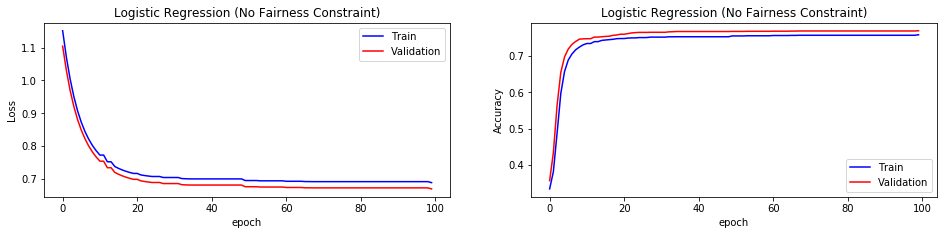

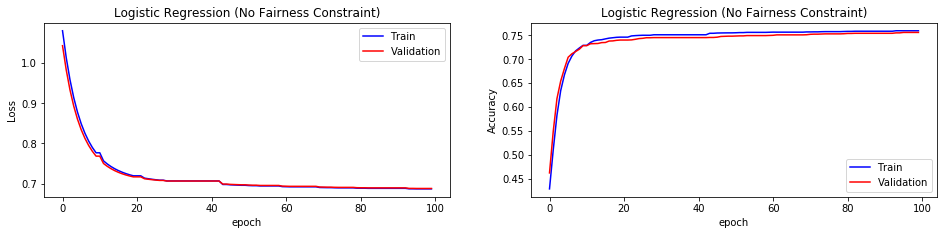

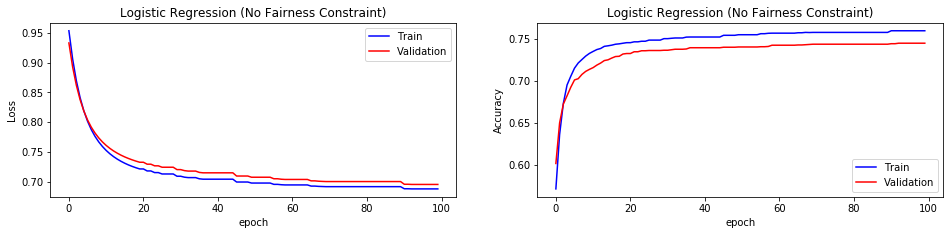

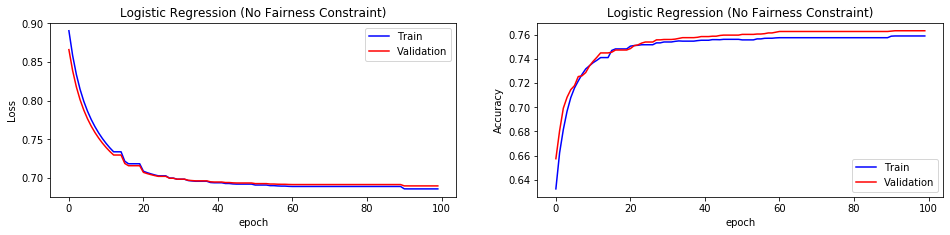

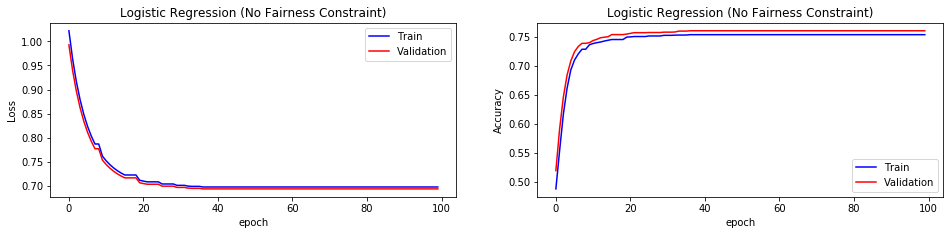

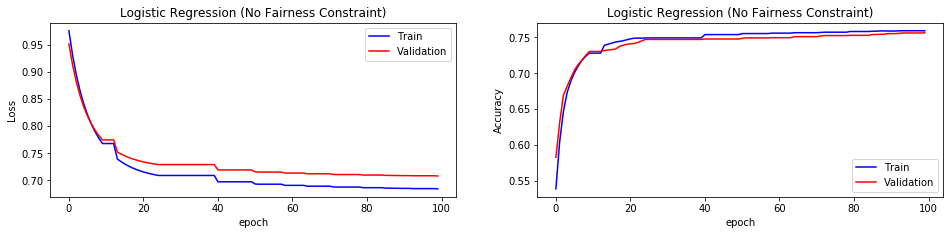

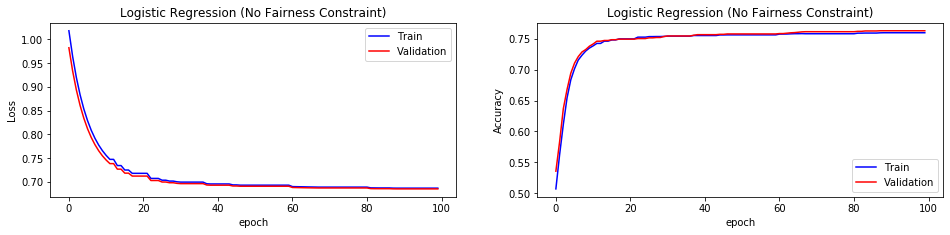

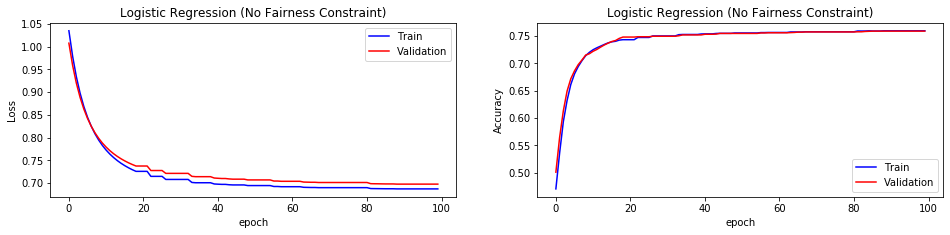

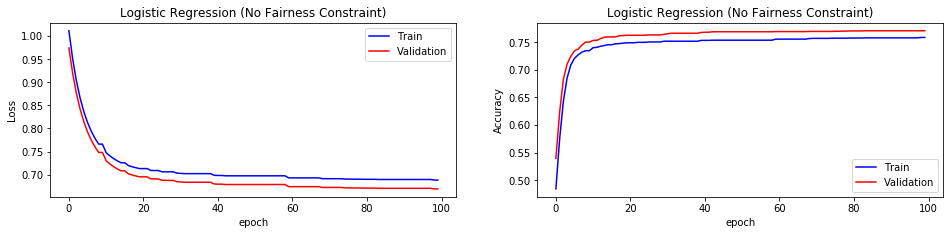

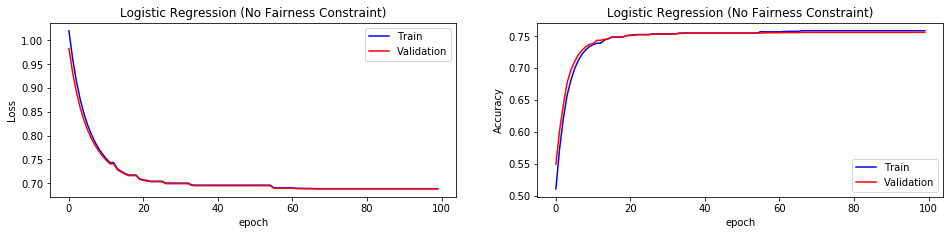

In [22]:
LR_f1s = []
LR_fnr_diffs = []
LR_fpr_diffs = []
LR_fnr_fprs = []
LR_aucs = []
LR_accs = []
LR_accs_o = []
LR_accs_p = []
e_valid_acc = 0

# Set hyperparameters
epochs = 100
lr = 0.0001
batch_size = 64

# Use 10 fold stratified cross-validation and record average and standard deviation of model scores
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    e_valid_acc = 0
    e_valid_fnr_fpr = 100
    X_train_, X_test_ = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = StandardScaler()

    X_train_[:, 0:7] = scaler.fit_transform(X_train_[:, 0:7])
    X_test_[:, 0:7] = scaler.fit_transform(X_test_[:, 0:7])

    X_train = X_train_
    X_test = X_test_

    training_features_tensor = torch.tensor(X_train, requires_grad=False, dtype=torch.float)
    training_labels_tensor = torch.tensor(y_train, requires_grad=False, dtype=torch.float)

    test_features_tensor = torch.tensor(X_test, requires_grad=False, dtype=torch.float)
    test_labels_tensor = torch.tensor(y_test, requires_grad=False, dtype=torch.float)
    
    # create Tensor datasets
    train_data = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor)
    val_data = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = False)
    valid_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last = False)

    model = LogisticRegression().to(device)

    # loss function - using cross entropy loss
    criterion = nn.BCELoss(weight = class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    

    for epoch in range(epochs):

        train_loss, train_acc, train_f1, train_auc = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_acc, valid_f1, valid_auc, _, _, p_mean, o_mean, p_fpr, o_fpr, p_fnr, o_fnr, acc_p, acc_o, f1_p, f1_o = evaluate(model, valid_loader, criterion)

        fnr_diff = np.abs((o_fnr - p_fnr))
        fpr_diff = np.abs((o_fpr - p_fpr))
        fnr_fpr_diff = (fnr_diff + fpr_diff)/2

        if valid_acc > e_valid_acc:
            e_train_loss = train_loss
            e_train_acc = train_acc
            e_train_f1 = train_f1
            e_train_auc = train_auc
            e_valid_acc = valid_acc
            e_valid_loss = valid_loss
            e_valid_f1 = valid_f1
            e_valid_auc = valid_auc
            e_valid_fnr_diff = fnr_diff
            e_valid_fpr_diff = fpr_diff
            e_valid_fnr_fpr = fnr_fpr_diff
            e_valid_o_fnr = o_fnr
            e_valid_o_fpr = o_fpr
            e_valid_p_fnr = p_fnr
            e_valid_p_fpr = p_fpr
            e_valid_o_acc = acc_o
            e_valid_p_acc = acc_p
            e_valid_o_f1 = f1_o
            e_valid_p_f1 = f1_p
            best_epoch = epoch

        if epoch%(epochs//10) == 0:

            print(f'Epoch: {epoch+1:02}')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
            print(f'\t Val Protected FPR: {p_fpr:.3f}')
            print(f'\t Val Other FPR: {o_fpr:.3f}')
            print(f'\t Val Protected FNR: {p_fnr:.3f}')
            print(f'\t Val Other FNR: {o_fnr:.3f}')

        train_losses.append(e_train_loss)
        train_accs.append(e_train_acc)

        val_losses.append(e_valid_loss)
        val_accs.append(e_valid_acc)

    title = "Logistic Regression (No Fairness Constraint)"
    plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, title)

    LR_f1s.append(e_valid_f1)
    LR_fnr_diffs.append(e_valid_fnr_diff)
    LR_fpr_diffs.append(e_valid_fpr_diff)
    LR_aucs.append(e_valid_auc)
    LR_accs.append(e_valid_acc)
    LR_accs_o.append(e_valid_o_acc)
    LR_accs_p.append(e_valid_p_acc)
    LR_fnr_fprs.append(e_valid_fnr_fpr)
    
    

Present results for Logistic Regression baseline model

In [23]:
data = {'a': 'LR', 'mean acc': np.mean(LR_accs), 'std acc': np.std(LR_accs), 'mean acc prot': np.mean(LR_accs_p),\
        'std acc prot': np.std(LR_accs_p), 'mean acc other': np.mean(LR_accs_o), 'std acc other': np.std(LR_accs_o),\
        'mean f1': np.mean(LR_f1s), 'std f1': np.std(LR_f1s),'mean auc': np.mean(LR_aucs),\
        'std auc': np.std(LR_aucs), 'mean FPR diff': np.mean(LR_fpr_diffs), 'std FPR diff': np.std(LR_fpr_diffs),\
        'mean FNR diff': np.mean(LR_fnr_diffs), 'std FNR diff': np.std(LR_fnr_diffs),\
        'mean av diffs': np.mean(LR_fnr_fprs), 'std av diffs': np.std(LR_fnr_fprs)}
results_df = pd.DataFrame (data, columns = ['a', 'mean acc', 'std acc', 'mean acc prot', 'std acc prot', 'mean acc other',\
                                            'std acc other', 'mean f1', 'std f1', 'mean auc', 'std auc', 'mean FPR diff', \
                                           'std FPR diff', 'mean FNR diff', 'std FNR diff', 'mean av diffs', \
                                           'std av diffs'], index = [0])
print(results_df)

    a  mean acc   std acc  mean acc prot  std acc prot  mean acc other  \
0  LR  0.759772  0.007044       0.749186      0.010118         0.76654   

   std acc other   mean f1    std f1  mean auc   std auc  mean FPR diff  \
0       0.009357  0.800145  0.005977  0.837426  0.006058       0.088495   

   std FPR diff  mean FNR diff  std FNR diff  mean av diffs  std av diffs  
0      0.021861       0.075259       0.01849       0.081877      0.013291  


[0.06800082702046403, 0.08459338148196155, 0.11547747225715564, 0.08170111047533844, 0.07730880995782521, 0.06970512881301916, 0.07203360252942029, 0.07732876748419729, 0.07883616293279025, 0.09378456044942139]
[0.8083937047214589, 0.7973040439340989, 0.7876969242310577, 0.8022088353413654, 0.8017861572810716, 0.7966867469879517, 0.8040674603174603, 0.7982940291018564, 0.8087239909751819, 0.7962870045158051]


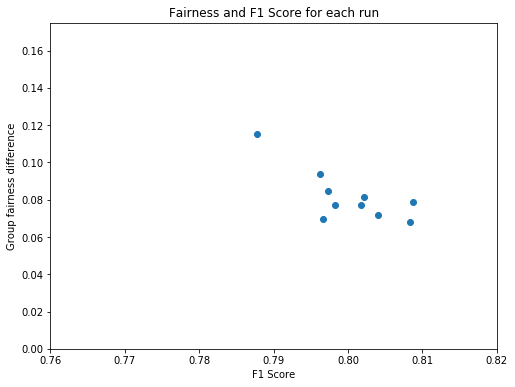

In [24]:
print(LR_fnr_fprs)
print(LR_f1s)

fig, ax = plt.subplots(figsize=(8,6))
plt.title('Fairness and F1 Score for each run')
plt.ylim((0, 0.175))
plt.xlim((0.76, 0.82))
plt.xlabel('F1 Score')
plt.ylabel('Group fairness difference')
plt.scatter(LR_f1s, LR_fnr_fprs)
plt.savefig('LR_runs.png')
plt.show()

Define and run model with institution features removed

In [25]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(7, 1)
    
    def forward(self, x):
        pred_logit = self.linear(x)
        y_pred = torch.sigmoid(pred_logit)
        y_pred = torch.squeeze(y_pred)
        return y_pred

In [34]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    e_pred_probs = np.array([])
    e_preds      = np.array([])
    e_labels = np.array([])
    model.train()

    for i, data in enumerate(iterator, 0):
        # get the inputs, select only the features that are not linked to the institution
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs_ni = inputs[:, (0, 1, 2, 3, 4, 5, 8)]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred_probs = model(inputs_ni)
        e_pred_probs = np.append(e_pred_probs, pred_probs.detach().cpu())
        loss = criterion(pred_probs, labels)
        pred = torch.round(pred_probs.detach().cpu().data) 
        acc = accuracy_score(labels.detach().cpu(), pred)
        e_preds = np.append(e_preds, pred.detach().cpu())
        e_labels = np.append(e_labels,labels.detach().cpu())
        
        loss.backward()
        optimizer.step()

        # capture loss and scores
        epoch_loss += loss.item()
        epoch_acc += acc.item()  
    
    f1 =  f1_score(e_labels,e_preds)
    auc = roc_auc_score(e_labels,e_pred_probs) 
            
    return epoch_loss/len(iterator) , epoch_acc / len(iterator), f1, auc

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_f1_o = 0
    epoch_f1_p = 0
    epoch_auc = 0
    epoch_prot_mean = 0
    epoch_other_mean = 0
    epoch_prot_fpr_mean = 0
    epoch_other_fpr_mean = 0
    epoch_prot_fnr_mean = 0
    epoch_other_fnr_mean = 0
    epoch_acc_p = 0
    epoch_acc_o = 0

    e_pred_probs = np.array([])
    e_preds      = np.array([])
    e_labels = np.array([])
    model.eval()
    
    with torch.no_grad():
    
        for i, data in enumerate(iterator, 0):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs_ni = inputs[:, (0, 1, 2, 3, 4, 5, 8)]

            pred_probs = model(inputs_ni)
            
            loss = criterion(pred_probs, labels)
            
            pred = torch.round(pred_probs.detach().cpu().data) 
            acc = accuracy_score(labels.detach().cpu(), pred)
            prot = inputs[:,feature_names.index('PROTECTED')] == 1
            other = inputs[:,feature_names.index('PROTECTED')] == 0
            acc_p = accuracy_score(labels.detach().cpu()[prot], pred[prot])
            acc_o = accuracy_score(labels.detach().cpu()[other], pred[other])
            f1_p = f1_score(labels.detach().cpu()[prot], pred[prot], zero_division=1)
            f1_o = f1_score(labels.detach().cpu()[other], pred[other], zero_division=1)
            prot_mean = pred[prot].mean()
            other_mean = pred[other].mean()

            # Check these expressions for fpr and fnr
            prot_fnr, prot_fpr = calc_FNR_FPR(labels.detach().cpu()[prot], pred[prot])
            other_fnr, other_fpr = calc_FNR_FPR(labels.detach().cpu()[other], pred[other])
            e_pred_probs = np.append(e_pred_probs, pred_probs.detach().cpu())
            e_preds = np.append(e_preds, pred.detach().cpu())
            e_labels = np.append(e_labels,labels.detach().cpu())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prot_mean += prot_mean
            epoch_other_mean += other_mean
            epoch_prot_fpr_mean += prot_fpr
            epoch_other_fpr_mean += other_fpr
            epoch_prot_fnr_mean += prot_fnr
            epoch_other_fnr_mean += other_fnr
            epoch_acc_p += acc_p
            epoch_acc_o += acc_o
            epoch_f1_o += f1_o
            epoch_f1_p += f1_p


    f1 =  f1_score(e_labels,e_preds)
    auc = roc_auc_score(e_labels,e_pred_probs) 

    n = len(iterator)
    return epoch_loss/n , epoch_acc /n, f1, auc, e_preds, e_pred_probs, epoch_prot_mean/n, epoch_other_mean/n, epoch_prot_fpr_mean/n, epoch_other_fpr_mean/n, epoch_prot_fnr_mean/n, epoch_other_fnr_mean/n, epoch_acc_p/n, epoch_acc_o/n, epoch_f1_p/n, epoch_f1_o/n

Epoch: 01
	Train Loss: 1.053 | Train Acc: 50.19%
	 Val. Loss: 1.037 |  Val. Acc: 52.16%
	 Val Protected FPR: 0.840
	 Val Other FPR: 0.826
	 Val Protected FNR: 0.227
	 Val Other FNR: 0.227
Epoch: 11
	Train Loss: 0.782 | Train Acc: 72.36%
	 Val. Loss: 0.774 |  Val. Acc: 72.30%
	 Val Protected FPR: 0.427
	 Val Other FPR: 0.495
	 Val Protected FNR: 0.168
	 Val Other FNR: 0.127
Epoch: 21
	Train Loss: 0.720 | Train Acc: 75.12%
	 Val. Loss: 0.710 |  Val. Acc: 75.75%
	 Val Protected FPR: 0.310
	 Val Other FPR: 0.387
	 Val Protected FNR: 0.188
	 Val Other FNR: 0.150
Epoch: 31
	Train Loss: 0.705 | Train Acc: 75.33%
	 Val. Loss: 0.692 |  Val. Acc: 76.32%
	 Val Protected FPR: 0.294
	 Val Other FPR: 0.362
	 Val Protected FNR: 0.197
	 Val Other FNR: 0.154
Epoch: 41
	Train Loss: 0.699 | Train Acc: 75.50%
	 Val. Loss: 0.685 |  Val. Acc: 76.32%
	 Val Protected FPR: 0.294
	 Val Other FPR: 0.359
	 Val Protected FNR: 0.193
	 Val Other FNR: 0.161
Epoch: 51
	Train Loss: 0.696 | Train Acc: 75.60%
	 Val. Loss

Epoch: 41
	Train Loss: 0.694 | Train Acc: 75.61%
	 Val. Loss: 0.691 |  Val. Acc: 76.38%
	 Val Protected FPR: 0.289
	 Val Other FPR: 0.362
	 Val Protected FNR: 0.188
	 Val Other FNR: 0.157
Epoch: 51
	Train Loss: 0.691 | Train Acc: 75.69%
	 Val. Loss: 0.689 |  Val. Acc: 76.17%
	 Val Protected FPR: 0.289
	 Val Other FPR: 0.356
	 Val Protected FNR: 0.199
	 Val Other FNR: 0.156
Epoch: 61
	Train Loss: 0.690 | Train Acc: 75.85%
	 Val. Loss: 0.687 |  Val. Acc: 75.99%
	 Val Protected FPR: 0.281
	 Val Other FPR: 0.365
	 Val Protected FNR: 0.207
	 Val Other FNR: 0.156
Epoch: 71
	Train Loss: 0.688 | Train Acc: 75.92%
	 Val. Loss: 0.686 |  Val. Acc: 76.17%
	 Val Protected FPR: 0.284
	 Val Other FPR: 0.357
	 Val Protected FNR: 0.209
	 Val Other FNR: 0.155
Epoch: 81
	Train Loss: 0.687 | Train Acc: 75.95%
	 Val. Loss: 0.685 |  Val. Acc: 75.99%
	 Val Protected FPR: 0.304
	 Val Other FPR: 0.357
	 Val Protected FNR: 0.205
	 Val Other FNR: 0.157
Epoch: 91
	Train Loss: 0.687 | Train Acc: 76.00%
	 Val. Loss

Epoch: 81
	Train Loss: 0.691 | Train Acc: 75.75%
	 Val. Loss: 0.672 |  Val. Acc: 77.43%
	 Val Protected FPR: 0.282
	 Val Other FPR: 0.327
	 Val Protected FNR: 0.205
	 Val Other FNR: 0.146
Epoch: 91
	Train Loss: 0.689 | Train Acc: 75.79%
	 Val. Loss: 0.671 |  Val. Acc: 77.31%
	 Val Protected FPR: 0.291
	 Val Other FPR: 0.319
	 Val Protected FNR: 0.212
	 Val Other FNR: 0.141
Epoch: 01
	Train Loss: 0.874 | Train Acc: 65.61%
	 Val. Loss: 0.865 |  Val. Acc: 65.46%
	 Val Protected FPR: 0.454
	 Val Other FPR: 0.501
	 Val Protected FNR: 0.296
	 Val Other FNR: 0.221
Epoch: 11
	Train Loss: 0.733 | Train Acc: 74.47%
	 Val. Loss: 0.729 |  Val. Acc: 74.87%
	 Val Protected FPR: 0.315
	 Val Other FPR: 0.376
	 Val Protected FNR: 0.224
	 Val Other FNR: 0.157


C:\Users\cathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
C:\Users\cathe\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Epoch: 21
	Train Loss: 0.710 | Train Acc: 75.16%
	 Val. Loss: 0.706 |  Val. Acc: 75.05%
	 Val Protected FPR: 0.287
	 Val Other FPR: 0.358
	 Val Protected FNR: 0.244
	 Val Other FNR: 0.168
Epoch: 31
	Train Loss: 0.702 | Train Acc: 75.48%
	 Val. Loss: 0.699 |  Val. Acc: 75.11%
	 Val Protected FPR: 0.282
	 Val Other FPR: 0.368
	 Val Protected FNR: 0.233
	 Val Other FNR: 0.168
Epoch: 41
	Train Loss: 0.697 | Train Acc: 75.64%
	 Val. Loss: 0.695 |  Val. Acc: 75.02%
	 Val Protected FPR: 0.292
	 Val Other FPR: 0.365
	 Val Protected FNR: 0.229
	 Val Other FNR: 0.168
Epoch: 51
	Train Loss: 0.694 | Train Acc: 75.76%
	 Val. Loss: 0.692 |  Val. Acc: 75.14%
	 Val Protected FPR: 0.280
	 Val Other FPR: 0.363
	 Val Protected FNR: 0.247
	 Val Other FNR: 0.164
Epoch: 61
	Train Loss: 0.691 | Train Acc: 75.80%
	 Val. Loss: 0.690 |  Val. Acc: 75.17%
	 Val Protected FPR: 0.281
	 Val Other FPR: 0.366
	 Val Protected FNR: 0.239
	 Val Other FNR: 0.169
Epoch: 71
	Train Loss: 0.689 | Train Acc: 75.94%
	 Val. Loss

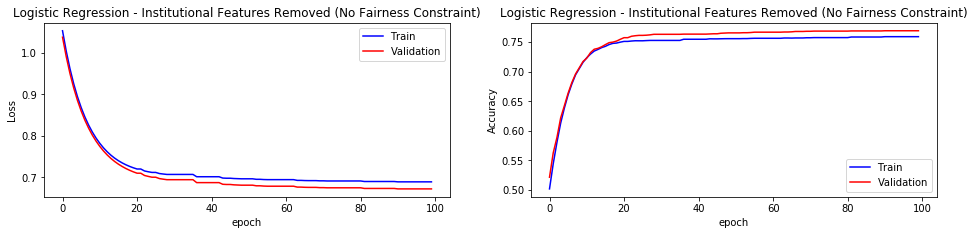

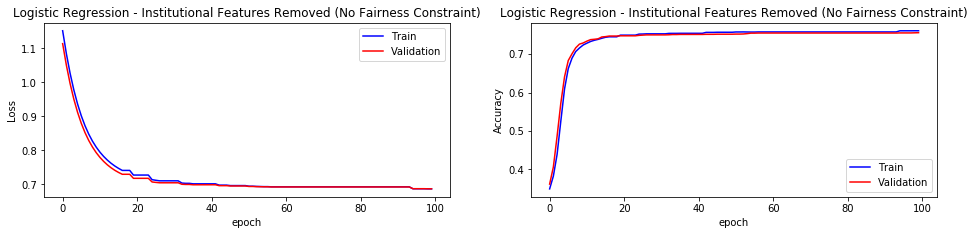

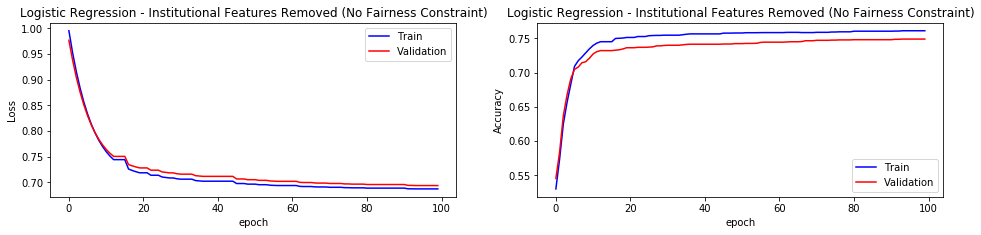

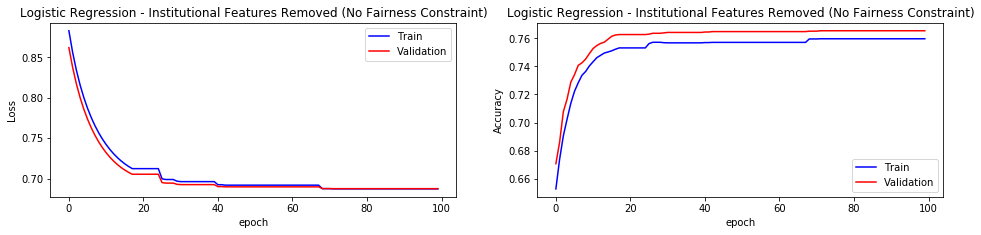

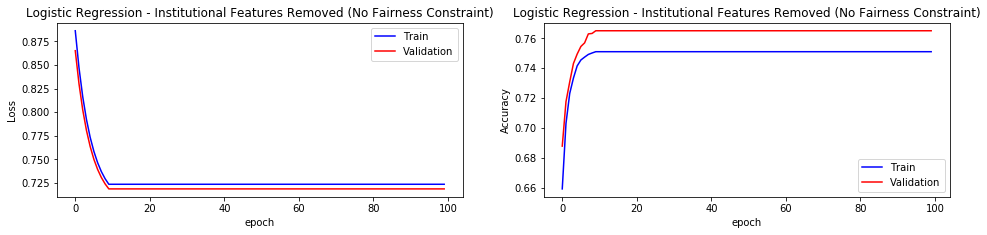

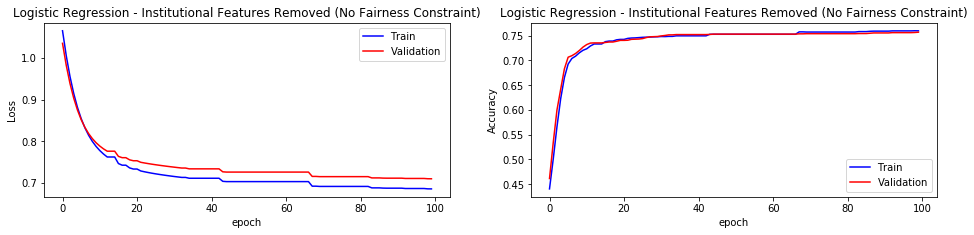

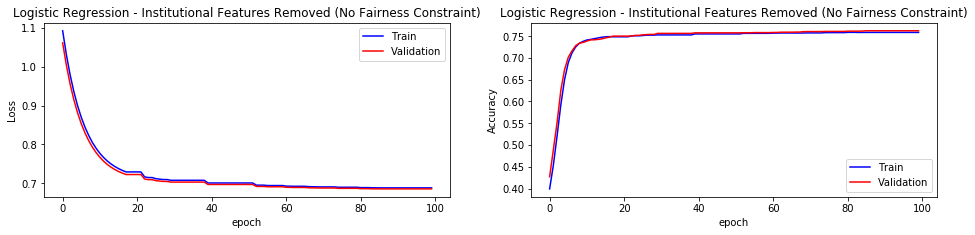

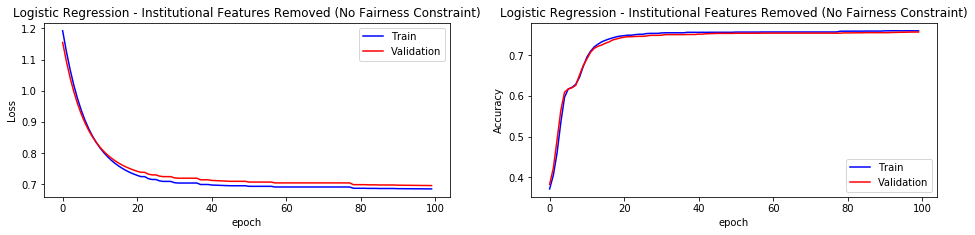

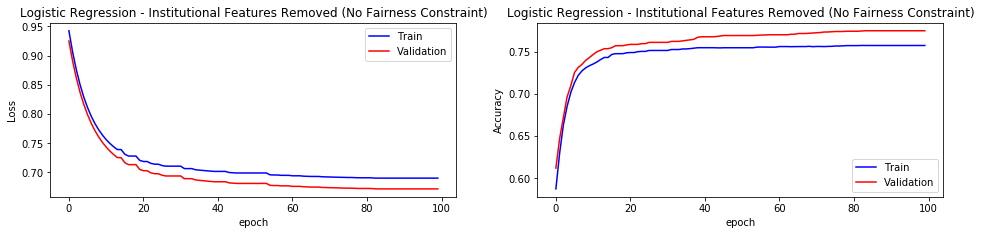

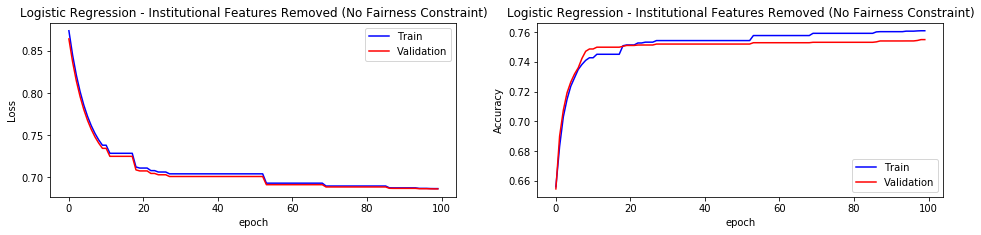

In [37]:
LR_f1s = []
LR_fnr_diffs = []
LR_fpr_diffs = []
LR_aucs = []
LR_accs = []
LR_accs_o = []
LR_accs_p = []

# Set hyperparameters
e_valid_acc = 0
epochs = 100
lr = 0.0001
batch_size = 64

# Use 10 fold stratified cross-validation and record average and standard deviation of model scores
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    e_valid_acc = 0
    e_valid_fnr_fpr = 1
    X_train_, X_test_ = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    scaler = StandardScaler()

    X_train_[:, 0:7] = scaler.fit_transform(X_train_[:, 0:7])
    X_test_[:, 0:7] = scaler.fit_transform(X_test_[:, 0:7])

    X_train = X_train_
    X_test = X_test_

    training_features_tensor = torch.tensor(X_train, requires_grad=False, dtype=torch.float)
    training_labels_tensor = torch.tensor(y_train, requires_grad=False, dtype=torch.float)

    test_features_tensor = torch.tensor(X_test, requires_grad=False, dtype=torch.float)
    test_labels_tensor = torch.tensor(y_test, requires_grad=False, dtype=torch.float)
    
    # create Tensor datasets
    train_data = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor)
    val_data = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = False)
    valid_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last = False)

    model = LogisticRegression().to(device)

    # loss function - using cross entropy loss
    criterion = nn.BCELoss(weight = class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    

    for epoch in range(epochs):

        train_loss, train_acc, train_f1, train_auc = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_acc, valid_f1, valid_auc, _, _, p_mean, o_mean, p_fpr, o_fpr, p_fnr, o_fnr, acc_p, acc_o, f1_p, f1_o = evaluate(model, valid_loader, criterion)

        fnr_diff = np.abs((o_fnr - p_fnr))
        fpr_diff = np.abs((o_fpr - p_fpr))


        if valid_acc > e_valid_acc:
            e_train_loss = train_loss
            e_train_acc = train_acc
            e_train_f1 = train_f1
            e_train_auc = train_auc
            e_valid_acc = valid_acc
            e_valid_loss = valid_loss
            e_valid_f1 = valid_f1
            e_valid_auc = valid_auc
            e_valid_fnr_diff = fnr_diff
            e_valid_fpr_diff = fpr_diff
            e_valid_o_fnr = o_fnr
            e_valid_o_fpr = o_fpr
            e_valid_p_fnr = p_fnr
            e_valid_p_fpr = p_fpr
            e_valid_o_acc = acc_o
            e_valid_p_acc = acc_p
            e_valid_o_f1 = f1_o
            e_valid_p_f1 = f1_p
            best_epoch = epoch

        if epoch%(epochs//10) == 0:

            print(f'Epoch: {epoch+1:02}')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
            print(f'\t Val Protected FPR: {p_fpr:.3f}')
            print(f'\t Val Other FPR: {o_fpr:.3f}')
            print(f'\t Val Protected FNR: {p_fnr:.3f}')
            print(f'\t Val Other FNR: {o_fnr:.3f}')

        train_losses.append(e_train_loss)
        train_accs.append(e_train_acc)

        val_losses.append(e_valid_loss)
        val_accs.append(e_valid_acc)

    title = "Logistic Regression - Institutional Features Removed (No Fairness Constraint)"
    plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, title)

    LR_f1s.append(e_valid_f1)
    LR_fnr_diffs.append(e_valid_fnr_diff)
    LR_fpr_diffs.append(e_valid_fpr_diff)
    LR_aucs.append(e_valid_auc)
    LR_accs.append(e_valid_acc)
    LR_accs_o.append(e_valid_o_acc)
    LR_accs_p.append(e_valid_p_acc)
    
    

In [38]:
data = {'a': 'LR', 'mean acc': np.mean(LR_accs), 'std acc': np.std(LR_accs), 'mean acc prot': np.mean(LR_accs_p),\
        'std acc prot': np.std(LR_accs_p), 'mean acc other': np.mean(LR_accs_o), 'std acc other': np.std(LR_accs_o),\
        'mean f1': np.mean(LR_f1s), 'std f1': np.std(LR_f1s),'mean auc': np.mean(LR_aucs),\
        'std auc': np.std(LR_aucs), 'mean FPR diff': np.mean(LR_fpr_diffs), 'std FPR diff': np.std(LR_fpr_diffs),\
        'mean FNR diff': np.mean(LR_fnr_diffs), 'std FNR diff': np.std(LR_fnr_diffs),\
        'mean av diffs': np.mean(LR_fpr_diffs + LR_fnr_diffs), 'std av diffs': np.std(LR_fpr_diffs + LR_fnr_diffs)}
results_df = pd.DataFrame (data, columns = ['a', 'mean acc', 'std acc', 'mean acc prot', 'std acc prot', 'mean acc other',\
                                            'std acc other', 'mean f1', 'std f1', 'mean auc', 'std auc', 'mean FPR diff', \
                                           'std FPR diff', 'mean FNR diff', 'std FNR diff', 'mean av diffs', \
                                           'std av diffs'], index = [0])
print(results_df)

    a  mean acc  std acc  mean acc prot  std acc prot  mean acc other  \
0  LR  0.761095  0.00741       0.750228      0.009609        0.767599   

   std acc other   mean f1    std f1  mean auc  std auc  mean FPR diff  \
0       0.010814  0.800675  0.006266  0.837289  0.00611       0.075827   

   std FPR diff  mean FNR diff  std FNR diff  mean av diffs  std av diffs  
0      0.030553       0.065599      0.017346       0.070713      0.025364  
